# Retrieval Augmented Generation (RAG) System Using Chat GPT With OpenAI

In [1]:
# !pip install openai -U
# !pip install llama-index llama-index-core llama-index-readers-file llama-index-llms-ollama llama-index-llms-huggingface llama-index-embeddings-huggingface llama-index-llms-openai llama-index-embeddings-openai -U
# !pip install spacy -U

In [1]:

import os
import torch
import tiktoken
# from openai import OpenAI as OpenAI_API
from llama_index.llms.openai import OpenAI
import matplotlib.pyplot as plt
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader, \
    ServiceContext, StorageContext, load_index_from_storage, get_response_synthesizer, \
    PromptTemplate, ChatPromptTemplate
from llama_index.core.response.pprint_utils import pprint_response
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.chat_engine import SimpleChatEngine, ContextChatEngine
from llama_index.core.postprocessor import SimilarityPostprocessor, MetadataReplacementPostProcessor
from llama_index.core.node_parser import  SentenceSplitter, SentenceWindowNodeParser
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.openai import OpenAIEmbedding
from dotenv import load_dotenv
load_dotenv()
# os.environ['HUGGINGFACE_API_KEY']=os.getenv("HUGGINGFACE_API_KEY")
# os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")


True

## Parameter Initialization

In [2]:
LLM_NAME = "gpt-3.5-turbo"                              # LLM model path from OpenAI
TOKENIZER_NAME = "gpt-3.5-turbo"                        # Tokenizer path from OpenAI
EMBED_MODEL_ID = "BAAI/bge-small-en-v1.5"               # Embedding model path from huggingface
# EMBED_MODEL_ID = "text-embedding-3-small"               # Embedding model path from OpenAI
# INPUT_DATA = './data/materials.md'                      # Path to the input data
INPUT_DATA_PATH = './material'                          # Path to the input data
QUESTION_LIST_PATH = './data/question_answer.csv'       # Path to the question list
VECTOR_STORE_DIR = "./vectorDB"                         # Path to the vector store directory
# VECTOR_STORE_DIR = "./vectorDB-OpenAI"                # Path to the vector store directory
CHUNK_SIZE = 256                                        # Chunk size for the vector store
OVERLAP_SIZE = 10                                       # Overlap size for the vector store
SIM_TOP_K = 4                                           # Top k similar documents
SYSTEM_PROMPT="""
You are an AI teaching Assistant for the SEP 775 course. 
You will provide an interactive platform for students to ask questions and receive guidance on course materials.
Your goal is to answer questions as accurately as possible based on the instructions and context provided.
If you found the answer based on the context provided, you should provide the answer first, then at the end, beginning a new sentence with the words "Source:", followed by the name of the lecture, or assignment, or paper if possible.
"""                                                     # create the instruction prompt                  


## GPT 3.5 Large Language Model (LLM) from OpenAI

In [3]:
# defaults to getting the key using os.environ.get("OPENAI_API_KEY")
# if you saved the key under a different environment variable name, you can do something like:
# client = OpenAI_API(
#   api_key=os.environ.get("OPENAI_API_KEY"),
# )
# print(client.api_key)

# completion = client.chat.completions.create(
#   model="gpt-3.5-turbo",
#   messages=[
#     {"role": "system", "content": "You are an AI teaching Assistant for the course SEP 775. \
#       You will provide an interactive platform for students to ask questions and receive guidance on course materials. \
#       Your goal is to answer questions as accurately as possible based on the instructions and context provided."},
#     {"role": "user", "content": "What is the Instructor name of the course SEP 775?"}
#   ]
# )

# print(completion.choices[0].message)
llm = OpenAI(
  temperature=0.3, 
  model=LLM_NAME, 
  system_prompt=SYSTEM_PROMPT,
)
Settings.llm = llm
Settings.tokenizer = tiktoken.encoding_for_model(TOKENIZER_NAME).encode

# non-streaming
resp = OpenAI().complete("What is the Instructor name of the course SEP 775?")
print(resp)


The instructor name of the course SEP 775 is Dr. John Smith.


## Retrieval Augmented Generation (RAG)

### Ingestion of data

In [4]:
documents = SimpleDirectoryReader(INPUT_DATA_PATH).load_data()
print("Number of Document:", len(documents))
print("Length of first Document:", len(documents[0].text))

Number of Document: 45
Length of first Document: 38464


### Embeddings

In [5]:
''' A vector embedding, often just called an embedding, 
is a numerical representation of the semantics, or meaning of your text. 
Two pieces of text with similar meanings will have mathematically similar embeddings, 
even if the actual text is quite different. '''

Settings.embed_model = HuggingFaceEmbedding(model_name=EMBED_MODEL_ID, max_length=1024)
# Settings.embed_model = OpenAIEmbedding(model=EMBED_MODEL_ID, max_length=1024)

### Split Data in Chunks

In [1]:
# Settings parameters
Settings.chunk_size = CHUNK_SIZE
Settings.chunk_overlap = OVERLAP_SIZE
Settings

#### Node Splitter

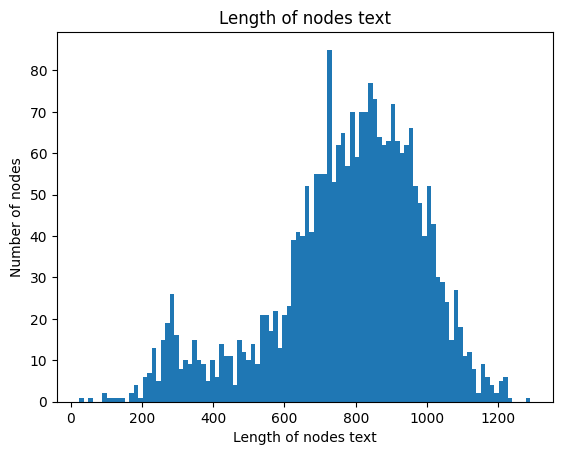

Node with max length: 1290
Number of nodes: 2518


In [7]:
# Create a splitter
splitter = SentenceSplitter(
    chunk_size=CHUNK_SIZE,          # lines per chunk
    chunk_overlap=OVERLAP_SIZE,     # overlap between chunks
)
# get nodes from documents
nodes = splitter.get_nodes_from_documents(documents)

length_nodes = [len(node.text) for node in nodes]
plt.title('Length of nodes text')
plt.hist(length_nodes, bins=100)
plt.xlabel('Length of nodes text')
plt.ylabel('Number of nodes')
plt.show()

# Get max length of nodes
max_length = max(length_nodes)
print("Node with max length:", max_length)

# Get the number of node
print("Number of nodes:", len(nodes))

#### Window Node Parser Testing

In [9]:
# # create node parser
# node_parser = SentenceWindowNodeParser.from_defaults(
#     # how many sentences on either side to capture
#     window_size=6,
#     # the metadata key that holds the window of surrounding sentences
#     window_metadata_key="window",
#     # the metadata key that holds the original sentence
#     original_text_metadata_key="original_sentence"
# )

# nodes = node_parser.get_nodes_from_documents(documents)

# # filter the nodes with the length in range [15, 800]
# nodes = [node for node in nodes if len(node.text) >= 15 and len(node.text) <= 800]


### Indexing and Storing to Vector Store

In [8]:
# check if storage already exists
if not os.path.exists(VECTOR_STORE_DIR):
    print("Creating New DB...")
    index = VectorStoreIndex.from_documents(documents)
    # index = VectorStoreIndex(nodes)
    # store it for later
    index.storage_context.persist(persist_dir=VECTOR_STORE_DIR)
else:
    print("Using Existing DB...")
    # load the existing index
    storage_context = StorageContext.from_defaults(persist_dir=VECTOR_STORE_DIR)
    index = load_index_from_storage(storage_context=storage_context)

# index = VectorStoreIndex.from_documents(documents)

Using Existing DB...


### Querying

In [9]:
# # basic method to query the index
# query_engine = index.as_query_engine()

# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=SIM_TOP_K,
)

# configure postprocessor
postprocessor = SimilarityPostprocessor(
    similarity_cutoff=0.30,
)

# configure response synthesizer
response_synthesizer = get_response_synthesizer()

# assemble query engine
query_engine=RetrieverQueryEngine(
    retriever=retriever, 
    response_synthesizer=response_synthesizer,
    node_postprocessors=[postprocessor],
)

### Prompt Engineering

#### Update Chat Prompt

In [10]:
# create a chat template for the QA task
qa_prompt_str = (
    "Context information below is related to the course: SEP 775 - Computational Natural Language Processing.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the question: {query_str}\n"
)

# Text QA Prompt
chat_text_qa_msgs = [
    ChatMessage(
        role=MessageRole.SYSTEM,
        content=(
            "Always answer the question, even if the context isn't helpful."
        ),
    ),
    ChatMessage(role=MessageRole.USER, content=qa_prompt_str),
]
text_qa_template = ChatPromptTemplate(chat_text_qa_msgs)

# add a memory buffer to the chat engine
memory = ChatMemoryBuffer.from_defaults(token_limit=1024)

chat_engine = index.as_chat_engine(
    chat_mode="context",
    verbose=False,
    memory=memory,
    system_prompt=(SYSTEM_PROMPT),
    text_qa_template=text_qa_template,
    similarity_top_k=SIM_TOP_K,
    # node_postprocessors=[
    #     MetadataReplacementPostProcessor(target_metadata_key="window")
    # ],
)

#### Update Query Prompt

In [11]:
from IPython.display import Markdown, display
# # define prompt viewing function
# def display_prompt_dict(prompts_dict):
#     for k, p in prompts_dict.items():
#         text_md = f"**Prompt Key**: {k}<br>" f"**Text:** <br>"
#         display(Markdown(text_md))
#         print(p.get_template())
#         display(Markdown("<br><br>"))
        
# display_prompt_dict(query_engine.get_prompts())

# Create a prompt template for the QA task
qa_prompt_tmpl_str = (
    "Below is the context information related to a course: SEP 775 - Computational Natural Language Processing.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_prompt_tmpl = PromptTemplate(qa_prompt_tmpl_str)

# Update the prompt in the query engine
query_engine.update_prompts({"response_synthesizer:text_qa_template": qa_prompt_tmpl})

### Simple Testing

In [12]:
question = "Who is the Instructor of the NLP course?"
response = chat_engine.chat(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: Who is the Instructor of the NLP course?
Answer: The instructor of the NLP course is Hamidreza Mahyar. 

Source: Course Outline 1.



In [13]:
pprint_response(response,show_source=True)
print(response)

Final Response: The instructor of the NLP course is Hamidreza Mahyar.
Source: Course Outline 1.
______________________________________________________________________
Source Node 1/4
Node ID: aaf5a613-d9f5-47b2-a0b5-cdd3b9009715
Similarity: 0.7254227059980587
Text: Course Outline 1. COURSE INFORMATION Session Offered Winter 2024
Course Name Introduction to Computational Natural Language Processing
Course Code SEP 775 Date s and Time s of lectures Lectures In person
Wednesday 3 30 pm 6 30 pm Program Name System and Technology Calendar
Description This graduate course introduces fundamental concepts in
compu...
______________________________________________________________________
Source Node 2/4
Node ID: e20ded9e-e709-46e0-ab0c-d50ec864a62f
Similarity: 0.7198413406483012
Text: COURSE SPECIFICS Course Description This course covers some
fundamental concepts in natural language processing NLP and how they
apply in real world use cases. Instruction Type Code Type Hours per
term C Classroom

In [14]:
question = "What is the Instructor's email address?"
response = chat_engine.chat(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: What is the Instructor's email address?
Answer: The instructor's email address is mahyarh@mcmaster.ca.

Source: Course Outline 1.



In [15]:
pprint_response(response,show_source=True)
print(response)

Final Response: The instructor's email address is mahyarh@mcmaster.ca.
Source: Course Outline 1.
______________________________________________________________________
Source Node 1/4
Node ID: 1dfca32f-33cc-4323-9ebb-19316184dfbe
Similarity: 0.6617744299151788
Text: . Students should be aware that when they access the electronic
components of a course using these elements private information such
as first and last names user names for the McMaster e mail accounts
and program affiliation may become apparent to all other students in
the same course. The available information is dependent on the
technology use...
______________________________________________________________________
Source Node 2/4
Node ID: b19f3e33-f549-412c-baea-0c21dad776f8
Similarity: 0.648215664043978
Text: Regularly check the official University communications channels.
Official University communications are considered received if sent by
postal mail by fax or by e mail to the student s designated primary e
mail acc

In [18]:
# response.source_nodes[0].metadata["file_name"]
# response.source_nodes[0].score
# response

### Get all the responses from the question list

In [19]:
# Load question list from csv
import pandas as pd
df = pd.read_csv(QUESTION_LIST_PATH)
df

,queries,responses
0,What is the instructor's name for this course?,The instructor's name of the course is Hamidre...
1,What is the email address of the instructor fo...,The email address of the instructor is mahyarh...
2,When is this course held every week?,This course is held every Wednesday from 3:30p...
3,What is the name of the TA for this course?,The TA's name for this course is Reza Namazi.
4,What is Word2vec?,Word2vec is a framework for learning word vect...
...,...,...
85,What is the role of attention mechanisms in mu...,Attention mechanisms help in aligning and focu...
86,"What are contrastive models, and how do they c...","Contrastive models, like CLIP and ALIGN, use c..."
87,How do multimodal foundation models like Visua...,These models extend the BERT architecture to i...
88,What advancements have been made in evaluation...,"New benchmarks like COCO, VQA, and Hateful Mem..."


In [20]:
# df.to_json('./data/question_answer.json', orient='records')

# idx = 0
# for question in df['Question']:
#     response = query_engine.query(question)
#     pprint_response(response,show_source=True)
#     print(f"Question: {question}\nAnswer: {response}\n")
#     idx+=1
#     if idx > 5:
#         break

In [21]:
# # Convert the dataframe to json, save the dataformat as 
# # { "queries": { "ramdom id": "question", ..., }, "responses": { "ramdom id": "answer", ..., }}
# import json
# data = df.to_dict()
# # Save the data to a json file
# with open('./data/question_answer.json', 'w') as f:
#     json.dump(data, f)
# data

## Evaluation

### Generate Question Response Pairs

In [22]:
# import random
# from llama_index.core.evaluation import (DatasetGenerator, QueryResponseDataset)

# # Generate question response pairs
# # the number of nodes to evaluate
# num_nodes_eval = 2
# num_query_eval = 10

# # selecting a random sample of nodes
# sample_eval_nodes = random.sample(nodes, num_nodes_eval)

# # creating our dataset generator
# dataset_generator = DatasetGenerator(
#     sample_eval_nodes,
#     show_progress=True,
#     num_questions_per_chunk=1,
# )

# eval_dataset = await dataset_generator.agenerate_dataset_from_nodes(num=num_query_eval)
# eval_dataset.save_json("./data/question_answer_generated.json")
# eval_dataset = QueryResponseDataset.from_json("./data/question_answer_generated.json")

### Load Question Response Pairs

In [23]:
from llama_index.core.evaluation import QueryResponseDataset

# load the question response pairs from the json file
eval_dataset = QueryResponseDataset.from_json("./data/question_answer_short.json")
eval_dataset.queries


c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\llama_index\core\evaluation\dataset_generation.py:109: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return cls(**data)


{'0': "What is the instructor's name for this course?",
 '1': 'What is the email address of the instructor for this course?',
 '2': 'When is this course held every week?',
 '3': 'What is the name of the TA for this course?',
 '4': 'What is Word2vec?',
 '5': 'What are the main learning goals of the course?',
 '6': 'How is the course grade distributed?',
 '7': 'What is the policy for late submissions in this course?',
 '8': 'What does the course hope to teach regarding word vectors?',
 '9': 'How does Word2vec represent word meaning?',
 '10': 'What is the main focus of this lecture on neural networks?',
 '11': 'What are the non-linear functions mentioned for neural networks?',
 '12': 'What is the purpose of non-linearities in neural networks?',
 '13': 'What is cross entropy loss used for in PyTorch?',
 '14': 'What is the significance of the backpropagation algorithm?',
 '15': 'What does the Jacobian matrix represent in the context of neural networks?',
 '16': 'How is the derivative with r

### Evaluate Using Faithfulness, Relevancy, Semantic Similarity, 

- **FaithfulnessEvaluator** module measures if the response from a query engine matches any source nodes. This is useful for measuring if the response was hallucinated.
- **RelevancyEvaluator** module measures if the response + source nodes match the query. This is useful for measuring if the query was actually answered by the response.
- **SemanticSimilarityEvaluator** measures the quality of a question answering system by comparing the similarity between embeddings of the generated answer and the reference answer.

In [24]:
from llama_index.core.evaluation import (CorrectnessEvaluator, SemanticSimilarityEvaluator, RelevancyEvaluator, FaithfulnessEvaluator)
from llama_index.core.evaluation import BatchEvalRunner
import nest_asyncio
nest_asyncio.apply()

# Evaluation metrics provided by LlamaIndex
evaluator_c = CorrectnessEvaluator()
evaluator_s = SemanticSimilarityEvaluator()
evaluator_r = RelevancyEvaluator()
evaluator_f = FaithfulnessEvaluator()

evaluator_dict = {
    "faithfulness": evaluator_f,
    "relevancy": evaluator_r,
    # "correctness": evaluator_c,
    "semantic_similarity": evaluator_s,
}

runner = BatchEvalRunner(evaluator_dict, workers=2, show_progress=False)

eval_results = await runner.aevaluate_queries(
    query_engine=query_engine, 
    queries=eval_dataset.questions,
    reference=[qr[1] for qr in eval_dataset.qr_pairs],
)

In [25]:
# eval_results

In [26]:
# len(eval_results)
# print(eval_results["faithfulness"])
# print(eval_results["relevancy"])
# print(eval_results["semantic_similarity"])

### Show Currect Evaluation

In [27]:
# Create a pandas dataframe to store the results, with columns for the query, response, source, faithfulness, relevancy, and semantic similarity
import pandas as pd
display_data = pd.DataFrame(columns=["Query", "Response", "Source", "Faithfulness", "Relevancy", "Semantic Similarity"])

num_query = len(eval_results["faithfulness"])
for i in range(num_query):
    query = eval_results["faithfulness"][i].query
    response = eval_results["faithfulness"][i].response
    Source = eval_results["faithfulness"][i].contexts[0]
    faithfulness_passing = eval_results["faithfulness"][i].score
    relevancy_passing = eval_results["relevancy"][i].score
    semantic_similarity = eval_results["semantic_similarity"][i].score
    
    # Store the results in a dataframe
    display_data.loc[i] = [query, response, Source, faithfulness_passing, relevancy_passing, semantic_similarity]
    
display_data
    

,Query,Response,Source,Faithfulness,Relevancy,Semantic Similarity
0,What is the instructor's name for this course?,"The instructor's name for the course ""Introduc...",Instruction Type Code Type Hours per term C Cl...,0.0,0.0,0.498354
1,What is the email address of the instructor fo...,"I'm sorry, but based on the provided context i...",. Students should be aware that when they acce...,0.0,0.0,0.572940
2,When is this course held every week?,"The course ""Introduction to Computational Natu...",Course Outline 1. COURSE INFORMATION Session O...,1.0,1.0,0.643556
3,What is the name of the TA for this course?,The TA for this course is an AI TA designed to...,Project Objectives Automate FAQ Responses Deve...,1.0,1.0,0.534986
4,What is Word2vec?,Word2vec is a framework for learning word vect...,23 𝑃𝑤𝑡 2 𝑤𝑡 𝑃𝑤𝑡 1 𝑤𝑡Word2vec objective functio...,1.0,1.0,0.936275
5,What are the main learning goals of the course?,The main learning goals of the course include ...,Please read itWhat do we hope to teach A.k.a. ...,1.0,1.0,0.791309
6,How is the course grade distributed?,The course grade is distributed as follows:\n-...,A Week 12 Project presentation and Q A Week 13...,1.0,1.0,0.827821
7,What is the policy for late submissions in thi...,The policy for late submissions in this course...,4 Quizzes 10 Midterm 35 Final Group Project 1 ...,1.0,0.0,0.729005
8,What does the course hope to teach regarding w...,The course hopes to teach the foundations of e...,Please read itWhat do we hope to teach A.k.a. ...,1.0,1.0,0.722529
9,How does Word2vec represent word meaning?,Word2vec represents word meaning by weighing t...,For example the analogy king is to queen as ma...,1.0,1.0,0.856353


### Show Average Scores

In [28]:
# Calculate the average faithfulness, relevancy, and semantic similarity scores
avg_faithfulness = display_data["Faithfulness"].mean()
avg_relevancy = display_data["Relevancy"].mean()
avg_semantic_similarity = display_data["Semantic Similarity"].mean()
print(f"Average Faithfulness: {avg_faithfulness}")
print(f"Average Relevancy: {avg_relevancy}")
print(f"Average Semantic Similarity: {avg_semantic_similarity}")


Average Faithfulness: 0.9047619047619048
Average Relevancy: 0.8571428571428571
Average Semantic Similarity: 0.7632512197561855


### Save Evaluation Results

In [29]:
# The results should be stored in a csv file with the following columns:
# Model, Chunk Size, Overlap Size, Faithfulness, Relevancy, Semantic Similarity

# Initialize the results dataframe
# results = pd.DataFrame(columns=["Embedding Model", "Chunk Size", "Overlap Size", "Faithfulness", "Relevancy", "Semantic Similarity"])
# results.to_csv("./data/evaluation_results.csv", index=False)

# Append new results to the dataframe
results = pd.read_csv("./data/evaluation_results.csv")
results.loc[len(results)] = [EMBED_MODEL_ID, CHUNK_SIZE, OVERLAP_SIZE, avg_faithfulness, avg_relevancy, avg_semantic_similarity]

# Save the results to a csv file
results.to_csv("./data/evaluation_results.csv", index=False)



### Show Saved Evaluation Results

In [30]:
results = pd.read_csv("./data/evaluation_results.csv")
results

,Embedding Model,Chunk Size,Overlap Size,Faithfulness,Relevancy,Semantic Similarity
0,BAAI/bge-small-en-v1.5,256,10,1.000000,0.904762,0.840245
1,BAAI/bge-small-en-v1.5,256,20,1.000000,0.857143,0.837503
2,BAAI/bge-small-en-v1.5,128,10,0.952381,0.952381,0.828908
3,BAAI/bge-small-en-v1.5,128,20,0.952381,0.857143,0.840400
4,text-embedding-3-small,256,10,0.904762,1.000000,0.801619
5,text-embedding-3-small,256,20,0.952381,1.000000,0.788386
6,text-embedding-3-small,128,10,0.904762,0.952381,0.755510
7,text-embedding-3-small,128,20,0.904762,0.857143,0.763251


In [31]:
# from ragas.evaluation import evaluate

# result = evaluate(query_engine, metrics, eval_questions, eval_answers)

## Log Progress

In [32]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))